In [1]:
import sys
sys.path.append("/fp/homes01/u01/ec-krimhau/.local/lib/python3.11/site-packages")

In [2]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import wandb


In [4]:
WANDB_NOTEBOOK_NAME = "deberata_test"
wandb.login(key = "c1c0e1ac0b8de1d97570c33e2c7baed9f60de1f2") # API key


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [5]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


k7pqcy3p7w05


In [6]:
CONFIG = {"seed": 2022,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [7]:
def set_seed(seed=2022):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [8]:
def train_test_split(df, train_percent=.85, seed=2022):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [9]:
Chromium_df = pd.read_csv("Chromium_dataset_clean.csv" , index_col = 0)

# Drop NaN values and reset index of dataframe
Chromium_df = Chromium_df[Chromium_df['text'].notna()]
Chromium_df = Chromium_df.reset_index()
Chromium_df.drop(columns=["index"] , inplace=True)

In [10]:
TD_df = pd.read_csv("TD_dataset_clean.csv" , index_col = 0)

# Drop NaN values and reset index of dataframe
TD_df = TD_df[TD_df['text'].notna()]
TD_df = TD_df.reset_index()
TD_df.drop(columns=["index"], inplace=True)


In [11]:
JIRA_df = pd.read_csv("jira_TD_dataset.csv", index_col = 0)

# Drop NaN values and reset index of dataframe
JIRA_df = JIRA_df[JIRA_df['text'].notna()]
JIRA_df = JIRA_df.reset_index()
JIRA_df.drop(columns=["index"], inplace=True)


In [12]:
TD_df

,text,label
0,we didnt have time to do automated tests or gh...,1
1,user storyas a sre i would like to know that ...,1
2,please explain the process of having a backup ...,0
3,currently the first parse error in a codl docu...,0
4,please use this to only for bug reports for qu...,0
...,...,...
126301,when the adminlogin endpoint is successful an ...,0
126302,we have pretty similar code in scattered acros...,1
126303,is your feature request related to a problem ...,0
126304,batch downloads dont work in safari unless the...,1


In [13]:
train_td_df , test_td_df = train_test_split(TD_df)

In [14]:
df = train_td_df

In [15]:
df.reset_index(inplace = True)

In [16]:
df.drop(columns=["index"], inplace=True)

In [17]:
df

,text,label
0,\r\r,1
1,can fix this with maybe,1
2,problem statement\rthe import statements on te...,1
3,describe the bug\rfor token text the match doe...,0
4,update our python projects to the latest versi...,1
...,...,...
107355,issue descriptionfor the list loop component ...,1
107356,im trying to run some js code in goja that con...,0
107357,performance is a feature of vector that we sho...,1
107358,after recent changes the deployment failed on ...,0


In [18]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [19]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      0        20157
       1        15630
1      0        19923
       1        15864
2      0        20027
       1        15759
Name: count, dtype: int64

In [20]:
df

,text,label,kfold
0,\r\r,1,2
1,can fix this with maybe,1,2
2,problem statement\rthe import statements on te...,1,1
3,describe the bug\rfor token text the match doe...,0,1
4,update our python projects to the latest versi...,1,2
...,...,...,...
107355,issue descriptionfor the list loop component ...,1,2
107356,im trying to run some js code in goja that con...,0,1
107357,performance is a feature of vector that we sho...,1,1
107358,after recent changes the deployment failed on ...,0,0


In [21]:
class TD_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [22]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [23]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [24]:
class TD_Model(nn.Module):
    def __init__(self, model_name):
        super(TD_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [25]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [26]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [28]:
def all_classification_report(y_true, y_pred, target_names = ['Non_TD', 'TD'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_TD', 'TD'])
    ax.yaxis.set_ticklabels(['Non_TD', 'TD'])
    
    return  accuracy , f1score
    
    

In [29]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [30]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [31]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = TD_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = TD_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [32]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 2237/2237 [04:33<00:00,  8.19it/s, Epoch=1, LR=9.74e-6, Valid_Loss=0.322]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8922    0.8572    0.8743     20157
          TD     0.8247    0.8665    0.8451     15630

    accuracy                         0.8612     35787
   macro avg     0.8585    0.8618    0.8597     35787
weighted avg     0.8627    0.8612    0.8616     35787

Accuracy = 0.8612
F1_score = 0.8451
Validation Loss Improved (inf ---> 0.3222067291969712)
Model Saved



100%|██████████| 2237/2237 [04:33<00:00,  8.19it/s, Epoch=2, LR=9e-6, Valid_Loss=0.295]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.9096    0.8593    0.8837     20157
          TD     0.8306    0.8898    0.8592     15630

    accuracy                         0.8726     35787
   macro avg     0.8701    0.8746    0.8715     35787
weighted avg     0.8751    0.8726    0.8730     35787

Accuracy = 0.8726
F1_score = 0.8592
Validation Loss Improved (0.3222067291969712 ---> 0.2946232385671285)
Model Saved



100%|██████████| 2237/2237 [04:33<00:00,  8.18it/s, Epoch=3, LR=7.86e-6, Valid_Loss=0.304]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8988    0.8825    0.8906     20157
          TD     0.8519    0.8718    0.8618     15630

    accuracy                         0.8778     35787
   macro avg     0.8753    0.8772    0.8762     35787
weighted avg     0.8783    0.8778    0.8780     35787

Accuracy = 0.8778
F1_score = 0.8618

Training complete in 1h 49m 47s
Best Loss: 0.2946


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▄▁
Valid Accuracy,▁▆█
Valid F1_score,▁▇█
Valid Loss,█▁▃
Best Loss,0.29462
Train Loss,0.23975
Valid Accuracy,0.8778
Valid F1_score,0.8618
Valid Loss,0.30434



====== Fold: 1 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 2237/2237 [04:38<00:00,  8.04it/s, Epoch=1, LR=9.74e-6, Valid_Loss=0.315]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8880    0.8658    0.8768     19923
          TD     0.8366    0.8629    0.8496     15864

    accuracy                         0.8645     35787
   macro avg     0.8623    0.8644    0.8632     35787
weighted avg     0.8652    0.8645    0.8647     35787

Accuracy = 0.8645
F1_score = 0.8496
Validation Loss Improved (inf ---> 0.314824177559488)
Model Saved



100%|██████████| 2237/2237 [04:38<00:00,  8.04it/s, Epoch=2, LR=9e-6, Valid_Loss=0.304]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.9128    0.8410    0.8754     19923
          TD     0.8183    0.8991    0.8568     15864

    accuracy                         0.8668     35787
   macro avg     0.8655    0.8701    0.8661     35787
weighted avg     0.8709    0.8668    0.8672     35787

Accuracy = 0.8668
F1_score = 0.8568
Validation Loss Improved (0.314824177559488 ---> 0.3042779894251134)
Model Saved



100%|██████████| 2237/2237 [04:38<00:00,  8.04it/s, Epoch=3, LR=7.86e-6, Valid_Loss=0.321]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8498    0.9236    0.8852     19923
          TD     0.8923    0.7951    0.8409     15864

    accuracy                         0.8666     35787
   macro avg     0.8711    0.8593    0.8630     35787
weighted avg     0.8686    0.8666    0.8655     35787

Accuracy = 0.8666
F1_score = 0.8409

Training complete in 1h 50m 29s
Best Loss: 0.3043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▄▁
Valid Accuracy,▁█▇
Valid F1_score,▅█▁
Valid Loss,▅▁█
Best Loss,0.30428
Train Loss,0.24223
Valid Accuracy,0.8666
Valid F1_score,0.8409
Valid Loss,0.3211



====== Fold: 2 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 2237/2237 [04:32<00:00,  8.20it/s, Epoch=1, LR=9.74e-6, Valid_Loss=0.337]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8278    0.9296    0.8758     20027
          TD     0.8940    0.7543    0.8182     15759

    accuracy                         0.8524     35786
   macro avg     0.8609    0.8420    0.8470     35786
weighted avg     0.8570    0.8524    0.8504     35786

Accuracy = 0.8524
F1_score = 0.8182
Validation Loss Improved (inf ---> 0.33702401882718847)
Model Saved



100%|██████████| 2237/2237 [04:32<00:00,  8.22it/s, Epoch=2, LR=9e-6, Valid_Loss=0.312]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.9054    0.8519    0.8778     20027
          TD     0.8249    0.8869    0.8548     15759

    accuracy                         0.8673     35786
   macro avg     0.8652    0.8694    0.8663     35786
weighted avg     0.8700    0.8673    0.8677     35786

Accuracy = 0.8673
F1_score = 0.8548
Validation Loss Improved (0.33702401882718847 ---> 0.3120826278180625)
Model Saved



100%|██████████| 2237/2237 [04:32<00:00,  8.21it/s, Epoch=3, LR=7.86e-6, Valid_Loss=0.342]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8241    0.9468    0.8812     20027
          TD     0.9167    0.7433    0.8209     15759

    accuracy                         0.8572     35786
   macro avg     0.8704    0.8450    0.8511     35786
weighted avg     0.8649    0.8572    0.8547     35786

Accuracy = 0.8572
F1_score = 0.8209

Training complete in 1h 50m 23s
Best Loss: 0.3121


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▄▁
Valid Accuracy,▁█▃
Valid F1_score,▁█▂
Valid Loss,▇▁█
Best Loss,0.31208
Train Loss,0.23776
Valid Accuracy,0.8572
Valid F1_score,0.8209
Valid Loss,0.34189


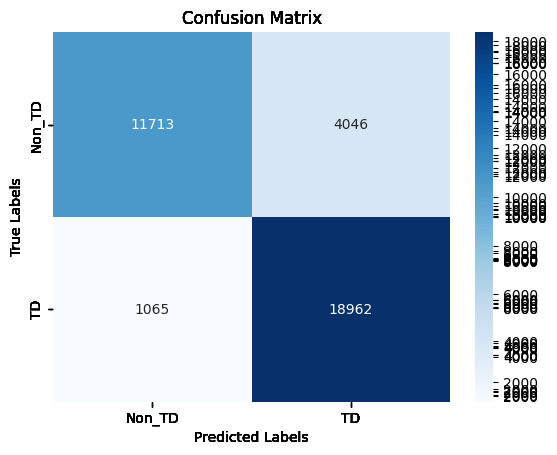

In [33]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='TD_Paper_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = TD_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [34]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [35]:
test_df = test_td_df

In [36]:
test_df

,text,label
116263,some logic has been extracted into lsifprotoco...,1
73271,music less than half no music at all in the ...,0
92484,egui on macos with winit wgpu backend\r\rim...,0
58196,pleaes update jenkins file with hello,0
23702,cloned from,1
...,...,...
46769,please\r\r check for duplicate issues\r prov...,0
103024,what happenedissue template featurerequestyml...,0
16557,a user is unable to delete or remove their soc...,0
1244,recovering user account,0


In [37]:
class TD_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [38]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = TD_Model(CONFIG['model_name'])

In [39]:
def prepare_test_loader(test_df):    
    test_dataset = TD_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [40]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [41]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 1185/1185 [02:23<00:00,  8.27it/s]


Fold 1


100%|██████████| 1185/1185 [02:23<00:00,  8.26it/s]


Fold 2


100%|██████████| 1185/1185 [02:23<00:00,  8.26it/s]


In [42]:
deberta_predictions


[array([[0.0099883 , 0.99001175],
        [0.801623  , 0.19837695],
        [0.9392785 , 0.06072153],
        ...,
        [0.94109696, 0.05890299],
        [0.95305675, 0.04694323],
        [0.5614298 , 0.43857014]], dtype=float32),
 array([[0.01552718, 0.9844728 ],
        [0.9269434 , 0.07305662],
        [0.9467624 , 0.05323761],
        ...,
        [0.9585459 , 0.04145407],
        [0.9453697 , 0.0546303 ],
        [0.46188316, 0.5381168 ]], dtype=float32),
 array([[0.00361113, 0.9963889 ],
        [0.9528608 , 0.04713921],
        [0.9744359 , 0.02556407],
        ...,
        [0.9854032 , 0.01459684],
        [0.94129896, 0.05870106],
        [0.56495017, 0.4350498 ]], dtype=float32)]

In [43]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.00970887, 0.9902911 ],
       [0.8938091 , 0.10619094],
       [0.95349234, 0.04650773],
       ...,
       [0.961682  , 0.03831796],
       [0.94657516, 0.05342487],
       [0.52942103, 0.4705789 ]], dtype=float32)

In [44]:
len(predictions)

18946

In [45]:
predictions

array([[0.00970887, 0.9902911 ],
       [0.8938091 , 0.10619094],
       [0.95349234, 0.04650773],
       ...,
       [0.961682  , 0.03831796],
       [0.94657516, 0.05342487],
       [0.52942103, 0.4705789 ]], dtype=float32)

In [46]:
test_df["prediction_0"] = predictions[:, 0] 

In [47]:
test_df["prediction_1"] = predictions[:, 1] 

In [48]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [49]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
116263,some logic has been extracted into lsifprotoco...,1,0.009709,0.990291,1,1,1
73271,music less than half no music at all in the ...,0,0.893809,0.106191,0,0,0
92484,egui on macos with winit wgpu backend\r\rim...,0,0.953492,0.046508,0,0,0
58196,pleaes update jenkins file with hello,0,0.326398,0.673602,1,1,0
23702,cloned from,1,0.133774,0.866226,1,1,1
...,...,...,...,...,...,...,...
46769,please\r\r check for duplicate issues\r prov...,0,0.989748,0.010252,0,0,0
103024,what happenedissue template featurerequestyml...,0,0.996285,0.003715,0,0,0
16557,a user is unable to delete or remove their soc...,0,0.961682,0.038318,0,0,0
1244,recovering user account,0,0.946575,0.053425,0,0,0


In [50]:
len(test_df)

18946

In [51]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [52]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [53]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [54]:
test_df["pred"] = test_df["pred"].astype(int)

In [55]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
116263,some logic has been extracted into lsifprotoco...,1,0.009709,0.990291,1,1,1,prediction_1,1
73271,music less than half no music at all in the ...,0,0.893809,0.106191,0,0,0,prediction_0,0
92484,egui on macos with winit wgpu backend\r\rim...,0,0.953492,0.046508,0,0,0,prediction_0,0
58196,pleaes update jenkins file with hello,0,0.326398,0.673602,1,1,0,prediction_1,1
23702,cloned from,1,0.133774,0.866226,1,1,1,prediction_1,1
...,...,...,...,...,...,...,...,...,...
46769,please\r\r check for duplicate issues\r prov...,0,0.989748,0.010252,0,0,0,prediction_0,0
103024,what happenedissue template featurerequestyml...,0,0.996285,0.003715,0,0,0,prediction_0,0
16557,a user is unable to delete or remove their soc...,0,0.961682,0.038318,0,0,0,prediction_0,0
1244,recovering user account,0,0.946575,0.053425,0,0,0,prediction_0,0


In [56]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[9027 1528]
 [ 875 7516]]


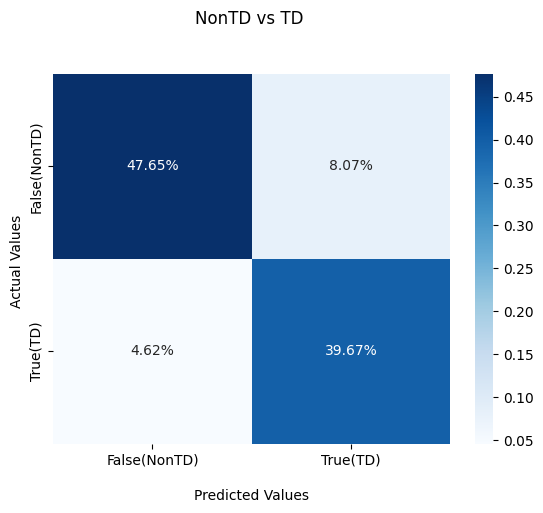

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('NonTD vs TD \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonTD)','True(TD)'])
ax.yaxis.set_ticklabels(['False(NonTD)','True(TD)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [58]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88     10555
           1       0.83      0.90      0.86      8391

    accuracy                           0.87     18946
   macro avg       0.87      0.88      0.87     18946
weighted avg       0.88      0.87      0.87     18946

